goal:
=====

to build a model takes sparse X = x_{i,j} with i in [0,n], j in [0,m] and y, a n-dimensional label vector. we then build a k-rank latent representation of the i's and j's such that we minimize ||y_i - \sum_i u_i * v_j||, an inner product that minimizes loss between an example's label and an inner product between the item's embedding and the embedding induced by all item factors

In [1]:
# import this stuff
import time
import sys
from pylab import *
from scipy import sparse
import numpy as np

import tensorflow as tf

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [2]:
def factorize(observed_features,
              labels,
              observed_features_validation,
              labels_validation,
              rank,
              max_iter=100,
              batch_size = 100,
              verbose=False,
              lambda_v=0,
              lambda_u=0,
              epsilon=0.001,
              optimizer=tf.train.AdamOptimizer(),
              seed=12345):

    # Extract info about shapes etc from the training data
    num_items = observed_features.shape[0]
    num_features = observed_features.shape[1]
    num_classes = labels.shape[1]
 
    U = tf.Variable(tf.truncated_normal([rank, num_features], stddev=0.2, mean=0, seed=seed), name="item_explainers")
    v_prime = tf.Variable(tf.truncated_normal([num_classes, rank], stddev=0.2, mean=0, seed=seed), name="hyperplane")
    
    x = tf.placeholder(tf.float32, [None, num_features])
    y = tf.placeholder(tf.float32, [None, num_classes])
                           
    pred = tf.nn.softmax(tf.transpose(tf.matmul(v_prime, tf.matmul(U, tf.transpose(tf.nn.l2_normalize(x, dim=0))))))
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred + 0.0000000001), reduction_indices=1) + # this was causing nans if pred == 0
                          lambda_v*tf.nn.l2_loss(v_prime) + # regularization for v
                          lambda_u*tf.nn.l2_loss(U)) # regularization for U
    
    norm = tf.nn.l2_loss(v_prime)
    optimize = optimizer.minimize(cost)
    
    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
        sess.run(init)
        last_cost = 1000000
        for iter in range(0, max_iter):
            avg_cost = 0
            batches = int(np.ceil(num_items/batch_size))
            xs = np.array_split(observed_features, batches)
            ys = np.array_split(labels, batches)
            
            for i in range(batches):
                _, c, n = sess.run([optimize, cost, norm],
                                   feed_dict={x:xs[i], y:ys[i]})
                avg_cost += c / xs[i].shape[0]
            if verbose:
                print("epoch: %s, cost: %s, norm: %s" % (iter+1, avg_cost, n))

            # check for convergence
            if abs(avg_cost-last_cost)/avg_cost < epsilon:
                break
                
            last_cost = avg_cost
            
        if verbose:
            print("optimization finished")
        # test prediction
        predictions, test_costs, norm = sess.run([pred, cost, norm], feed_dict={x:observed_features_validation, y:labels_validation})
        return predictions, test_costs, norm

In [3]:
# use this data for now

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

ng = datasets.fetch_20newsgroups (categories=categories, shuffle=True)
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(ng.target.reshape(-1,1))

tfidf = TfidfVectorizer(decode_error=False, min_df=5)

X_train, X_test, y_train, y_test = train_test_split(ng.data, labels, test_size=.3)
X_train = tfidf.fit_transform(X_train).todense()
X_test = tfidf.transform(X_test).todense()


In [4]:
r = 10
predictions, test_costs, norm = factorize(X_train, y_train, X_test, y_test, r, verbose=True, lambda_v=0.1, max_iter=30)
print("rank: %s, cost: %s, norm: %s") % (r, test_costs, norm)
for i in range(y_train.shape[1]):
    print("class %s AUC: %s") % (i, roc_auc_score(y_test[:,i], predictions[:,i]))
print("overall AUC: %s") % roc_auc_score(y_test, predictions, average="weighted")

epoch: 1, cost: 0.215073817427, norm: 0.596143
epoch: 2, cost: 0.180462395556, norm: 0.570639
epoch: 3, cost: 0.155763792895, norm: 0.574589
epoch: 4, cost: 0.134517971825, norm: 0.603756
epoch: 5, cost: 0.115207956063, norm: 0.651018
epoch: 6, cost: 0.0978467426264, norm: 0.709026
epoch: 7, cost: 0.0828714005549, norm: 0.771263
epoch: 8, cost: 0.0705488203671, norm: 0.832494
epoch: 9, cost: 0.0607936620525, norm: 0.888986
epoch: 10, cost: 0.0532501940136, norm: 0.938508
epoch: 11, cost: 0.0474621034536, norm: 0.980074
epoch: 12, cost: 0.0430006650339, norm: 1.01356
epoch: 13, cost: 0.0395179188985, norm: 1.03937
epoch: 14, cost: 0.0367513639827, norm: 1.05814
epoch: 15, cost: 0.0345099538203, norm: 1.07065
epoch: 16, cost: 0.0326568765768, norm: 1.07766
epoch: 17, cost: 0.0310945896099, norm: 1.07995
epoch: 18, cost: 0.0297533282721, norm: 1.0782
epoch: 19, cost: 0.0285828217436, norm: 1.07308
epoch: 20, cost: 0.0275464791185, norm: 1.06515
epoch: 21, cost: 0.0266173681507, norm: 1.05

## 

In [6]:
grid_aucs = {}
# grid search
ranks = [10]
lambda_Us = [0, 1, .1, .01, .001]
lambda_vs = [0, 1, .1, .01, .001]
for r in ranks:
    for u in lambda_Us:
        for v in lambda_vs:
            predictions, test_costs, norm = factorize(X_train, y_train, X_test, y_test, r, verbose=False, lambda_v=v, lambda_u=u, max_iter=200)
            auc = roc_auc_score(y_test, predictions, average="weighted")
            print("r: %s, u: %s, v: %s, overall AUC: %s") % (r,u,v,auc)
            grid_aucs[(r,u,v)] = auc

r: 10, u: 0, v: 0, overall AUC: 0.993505565821
r: 10, u: 0, v: 1, overall AUC: 0.996364898046
r: 10, u: 0, v: 0.1, overall AUC: 0.995826972436
r: 10, u: 0, v: 0.01, overall AUC: 0.994840548021
r: 10, u: 0, v: 0.001, overall AUC: 0.993714559378
r: 10, u: 1, v: 0, overall AUC: 0.995636441006
r: 10, u: 1, v: 1, overall AUC: 0.585496141977
r: 10, u: 1, v: 0.1, overall AUC: 0.945075834952
r: 10, u: 1, v: 0.01, overall AUC: 0.983743957516
r: 10, u: 1, v: 0.001, overall AUC: 0.99544324486
r: 10, u: 0.1, v: 0, overall AUC: 0.997191261079
r: 10, u: 0.1, v: 1, overall AUC: 0.881502985975
r: 10, u: 0.1, v: 0.1, overall AUC: 0.993780330428
r: 10, u: 0.1, v: 0.01, overall AUC: 0.996836565669
r: 10, u: 0.1, v: 0.001, overall AUC: 0.997190158409
r: 10, u: 0.01, v: 0, overall AUC: 0.997203073472
r: 10, u: 0.01, v: 1, overall AUC: 0.993981344752
r: 10, u: 0.01, v: 0.1, overall AUC: 0.996881081108
r: 10, u: 0.01, v: 0.01, overall AUC: 0.996855149917
r: 10, u: 0.01, v: 0.001, overall AUC: 0.996924913396


`%matplotlib` prevents importing * from pylab and numpy
/Users/jattenberg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Populating the interactive namespace from numpy and matplotlib


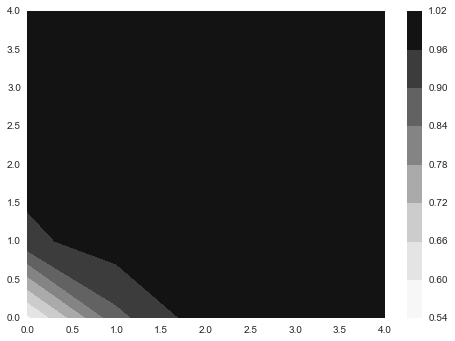

In [7]:

zs = np.array([[grid_aucs[(10,u,v)] for u in [1, .1, 0.01, 0.001, 0]] for v in [1, .1, 0.01, 0.001, 0]])

%pylab inline
plt.figure()
plt.contourf(zs)
plt.colorbar()
plt.grid('on')
